In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/fbprophet-0.6.1.dev0-py3.7.egg/fbprophet/diagnostics.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%%R
library(prophet)

R[write to console]: Loading required package: Rcpp

R[write to console]: Loading required package: rlang



### Forecasting Growth

By default, Prophet uses a linear model for its forecast. When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the carrying capacity, and the forecast should saturate at this point.

Prophet allows you to make forecasts using a [logistic growth](https://en.wikipedia.org/wiki/Logistic_function) trend model, with a specified carrying capacity. We illustrate this with the log number of page visits to the [R (programming language)](https://en.wikipedia.org/wiki/R_%28programming_language%29) page on Wikipedia:

In [3]:
%%R
df <- read.csv('../examples/example_wp_log_R.csv')

In [4]:
df = pd.read_csv('../examples/example_wp_log_R.csv')

We must specify the carrying capacity in a column `cap`. Here we will assume a particular value, but this would usually be set using data or expertise about the market size.

In [5]:
%%R
df$cap <- 8.5

In [6]:
df['cap'] = 8.5

The important things to note are that `cap` must be specified for every row in the dataframe, and that it does not have to be constant. If the market size is growing, then `cap` can be an increasing sequence.

We then fit the model as before, except pass in an additional argument to specify logistic growth:

In [7]:
%%R
m <- prophet(df, growth = 'logistic')

Initial log joint probability = -19.9808
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [8]:
m = Prophet(growth='logistic')
m.fit(df)

We make a dataframe for future predictions as before, except we must also specify the capacity in the future. Here we keep capacity constant at the same value as in the history, and forecast 5 years into the future:

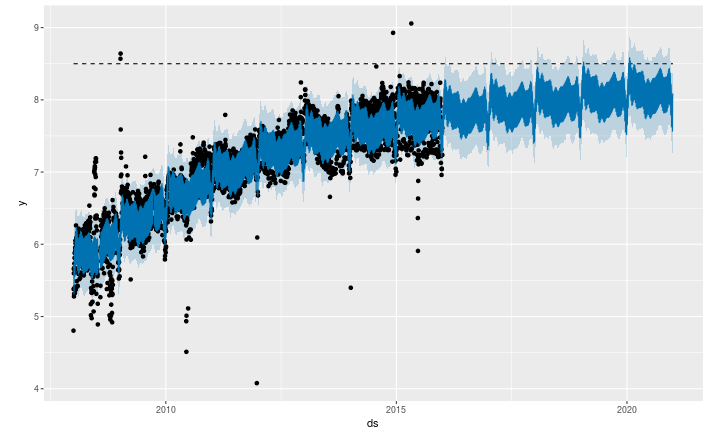

In [9]:
%%R -w 10 -h 6 -u in
future <- make_future_dataframe(m, periods = 1826)
future$cap <- 8.5
fcst <- predict(m, future)
plot(m, fcst)

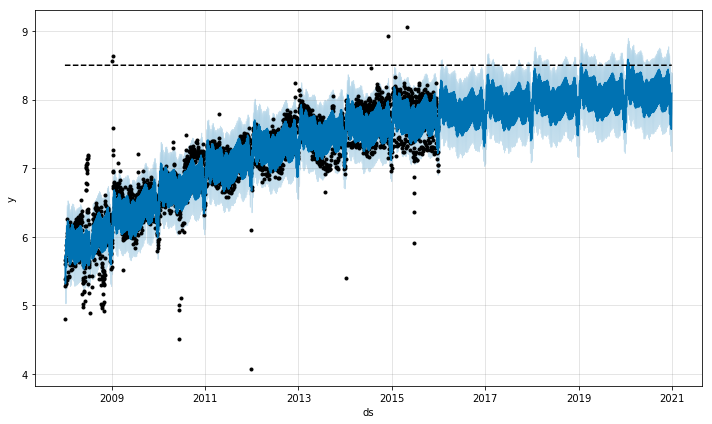

In [10]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

The logistic function has an implicit minimum of 0, and will saturate at 0 the same way that it saturates at the capacity. It is possible to also specify a different saturating minimum.

### Saturating Minimum

The logistic growth model can also handle a saturating minimum, which is specified with a column `floor` in the same way as the `cap` column specifies the maximum:

In [11]:
%%R -w 10 -h 6 -u in
df$y <- 10 - df$y
df$cap <- 6
df$floor <- 1.5
future$cap <- 6
future$floor <- 1.5
m <- prophet(df, growth = 'logistic')
fcst <- predict(m, future)
plot(m, fcst)

Initial log joint probability = -109.241
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


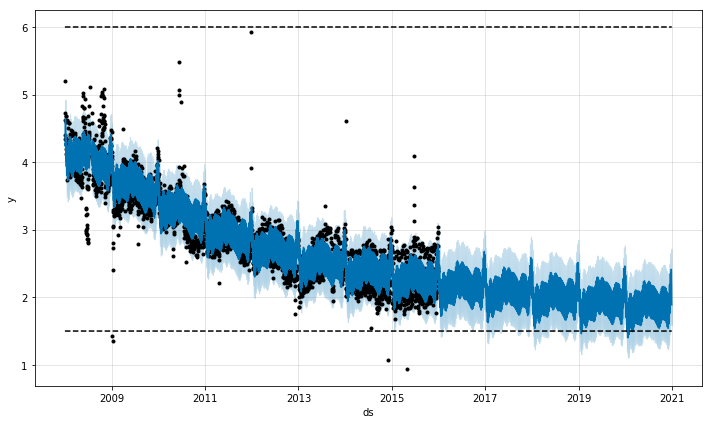

In [12]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.

### Constant Trend

For some datasets which exhibit strong seasonality patterns rather than trend changes, it may be useful to force the growth rate to be flat. This can be achieved simply by passing `growth=flat` before fitting the model. However, if used on a dataset with obvious non linear trend, most of the change in the trend would be fit with variance (high noise term) and hence we would observe a high predictive uncertainty.

In [3]:
m = Prophet(growth='flat')